In [40]:
# we'll use our solved image to identify catalog stars we can use to calibrate our magnitudes
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from photutils import DAOStarFinder 
from photutils import aperture_photometry, CircularAperture
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astroquery.vizier import Vizier
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import pandas as pd

# load the first frame (MUST BE SOLVED FIRST WITH ASTROMETRY.NET) (only the first frame needs to be solved)
image_file = "cdb_wcs_test.fits"
image_data = fits.getdata(image_file, ext=0)
image_header = fits.getheader(image_file, ext=0)
wcs = WCS(image_header)

# find the stars in the first frames (we assume that all the frames are aligned already, so the stars will be in the same place)
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std)
sources = daofind(image_data - median)
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)
ra_dec = wcs.pixel_to_world(sources['xcentroid'], sources['ycentroid'])
    # tableQTable or None
    #     A table of found stars with the following parameters:
    #         id: unique object identification number.
    #         xcentroid, ycentroid: object centroid.
    #         sharpness: object sharpness.
    #         roundness1: object roundness based on symmetry.
    #         roundness2: object roundness based on marginal Gaussian fits.
    #         npix: the total number of pixels in the Gaussian kernel array.
    #         sky: the input sky parameter.
    #         peak: the peak, sky-subtracted, pixel value of the object.
    #         flux: the object flux calculated as the peak density in the convolved image divided by the detection threshold. This derivation matches that of DAOFIND if sky is 0.0.
    #         mag: the object instrumental magnitude calculated as -2.5 * log10(flux). The derivation matches that of DAOFIND if sky is 0.0.
    #     None is returned if no stars are found.




/tmp/ipykernel_1204/977678876.py:5: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder
/tmp/ipykernel_1204/977678876.py:6: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry, CircularAperture
/tmp/ipykernel_1204/977678876.py:6: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import aperture_photometry, CircularAperture

 id xcentroid ycentroid sharpness  ... sky  peak    flux       mag     
--- --------- --------- ---------- ... --- ----- --------- ------------
  1 1259.0259 1.7973991 0.48266709 ...   0   478 26.937129   -3.5758783
  2 1576.5373 4.7919764 0.52302019 ...   0    31 1.1450116  -0.14702473
  3 1602.8553 4.5983533 0.28555844 ...   0    20 1.1240262  -0.12694112
  4   341.132 44.785937 0.37498212 ...   0   250 12.425438   -2.7357793
  5 775.79477 326.07171 0.26832697 ...   0    14 1.0617757 -0.065081926
  6 1249.4512 408.87066 0.30547727 ...   0   193  9.728851   -2.4701539
  7 1003.0436 454.28572 0.44834109 ...   0 14243 590.27052   -6.9276277
  8 1010.7272 703.02956 0.50633569 ...   0   287 12.431648   -2.7363218
  9 1567.5587 755.82863 0.45057396 ...   0  1760 79.099707   -4.7454372
 10 1000.8842 791.23854 0.45585617 ...   0  1697 75.883963    -4.700375
 11 1395.7769 813.38563 0.69370475 ...   0    97 3.5287274   -1.3690453
 12 1193.3351 871.97313 0.45907298 ...   0  2911 131.32819   -5.

In [25]:
# convert the x-y coordinates of the stars to RA-Dec
sources["RA"], sources["Dec"] = ra_dec.ra, ra_dec.dec
print(sources["RA", "Dec"])

        RA                Dec        
       deg                deg        
------------------ ------------------
19.753098471483362  13.36816736185409
19.752958669511894 13.388001564243922
19.752975936379766 13.389645523585159
19.750221321209548  13.31083130956745
19.732149808725033 13.338001481934258
19.726864327590015 13.367613122628187
19.723916119620892 13.352213191601521
19.707911586515962  13.35270647626872
19.704557744033508 13.387536387727318
19.702238237986975 13.352094189242338
 19.70083859829106 13.376796440551859
19.697056589474457 13.364136135124161
19.695700681508757 13.294669828357936
19.693528721107032 13.330994008483527
19.682562484108715 13.338985330737332
 19.67964970673177 13.336101173114923
 19.67142814853711 13.350783699623433
19.666015689258906 13.385715375154044
19.657148537419573 13.347358173080618
19.655237644882497  13.32901099067997


In [26]:
# find the stars in a catalog

# find the center of the image, query around it
center = wcs.pixel_to_world(image_data.shape[0]/2, image_data.shape[1]/2)
result = Vizier.query_region(coord.SkyCoord(ra=center.ra, dec=center.dec, 
                                            unit=(u.deg, u.deg),frame='icrs'),
                                            width="6m",catalog=["2MASS","SDSS"])
print(result)


TableList with 7 tables:
	'0:II/246/out' with 15 column(s) and 25 row(s) 
	'1:II/294/sdss7' with 19 column(s) and 50 row(s) 
	'2:V/139/sdss9' with 21 column(s) and 50 row(s) 
	'3:V/147/sdss12' with 23 column(s) and 50 row(s) 
	'4:V/154/sdss16' with 28 column(s) and 50 row(s) 
	'5:VII/289/dr16q' with 39 column(s) and 1 row(s) 
	'6:VII/289/superset' with 12 column(s) and 1 row(s) 


In [32]:
# choose catalog
catalog = "II/246/out"

In [33]:
# sort by ascending magnitude, output the top 10 to csv
result[catalog].sort("Jmag")
filtered_ref = result[catalog][:10]
filtered_ref.write("catalog.csv", format="csv",overwrite=True)
print(filtered_ref)
sources.sort("mag")
filtered_sources = sources[:10]
filtered_sources.write("ten_sources.csv", format="csv",overwrite=True)

 RAJ2000    DEJ2000        _2MASS       Jmag  e_Jmag ... Bflg Cflg Xflg Aflg
   deg        deg                       mag    mag   ...                    
---------- ---------- ---------------- ------ ------ ... ---- ---- ---- ----
 19.723956  13.352340 01185374+1321084  9.201  0.023 ...  111  000    0    0
 19.704475  13.387615 01184907+1323154 11.849  0.023 ...  111  000    0    0
 19.697123  13.364062 01184730+1321506 11.870  0.023 ...  111  000    0    0
 19.702133  13.352142 01184851+1321077 12.276  0.022 ...  111  000    0    0
 19.682587  13.339031 01184382+1320205 13.667  0.030 ...  111  000    0    0
 19.707806  13.352680 01184987+1321096 13.717  0.030 ...  111  000    0    0
 19.726781  13.367628 01185442+1322034 14.070  0.030 ...  111  000    0    0
 19.671232  13.350637 01184109+1321022 14.431  0.028 ...  111  000    0    0
 19.750166  13.310828 01190003+1318389 14.499  0.027 ...  111  000    0    0
 19.695753  13.294714 01184698+1317409 14.747  0.035 ...  111  000    0    0

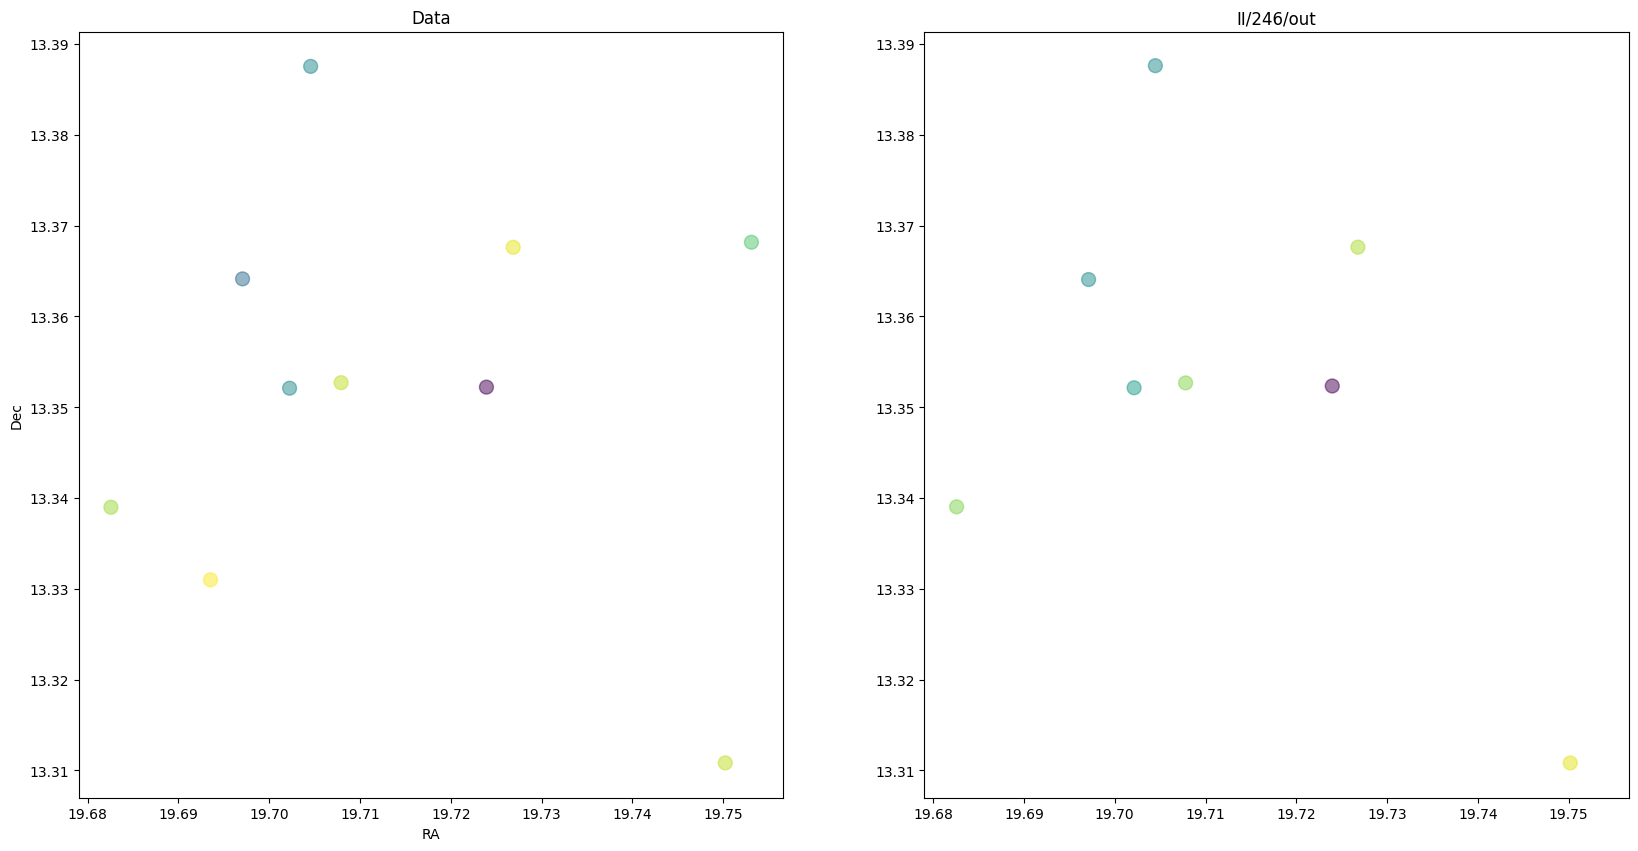

In [34]:
# side-by-side plot of the sources in the image and the catalog
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
ax1, ax2 = axes

ax1.scatter(filtered_sources['RA'], filtered_sources['Dec'], c=filtered_sources["mag"], s=100, alpha=0.5)
# add cbar to ax1
# cbar = fig.colorbar(ax1.collections[0], ax=ax1)

# cbar.set_label('Magnitude')
ax1.set_xlabel('RA')
ax1.set_ylabel('Dec')
ax1.set_title('Data')
ax1.set_aspect(1)
# apply ax1's x and y limits to ax2:
ax2.scatter(filtered_ref['RAJ2000'], filtered_ref['DEJ2000'], c=filtered_ref["Jmag"], s=100, alpha=0.5)
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
# make ax2 square 
ax2.set_aspect(1)
ax2.set_title(catalog)

plt.show()

In [45]:
# calculate the distance between each source and its nearest neighbor in the other catalog
max_allowed_distance = 0.002 # degrees

# create distance matrix
source_points = np.column_stack((np.array(filtered_sources["RA"]),np.array(filtered_sources["Dec"])))
ref_points = np.column_stack((np.array(filtered_ref["RAJ2000"]),np.array(filtered_ref["DEJ2000"])))

# calculate distance matrix
from scipy.spatial import distance_matrix
dist_matrix = distance_matrix(source_points, ref_points)

min_distances = np.min(dist_matrix, axis=1)
min_indices = np.argmin(dist_matrix, axis=1)

df_min_distances = pd.DataFrame({
    'min_distance': min_distances,
    'catalog_reference': min_indices
})
df_min_distances = df_min_distances[df_min_distances['min_distance'] < max_allowed_distance]
df_min_distances.sort_values(by=['catalog_reference', 'min_distance'], inplace=True)
print(df_min_distances)
df_min_distances.drop_duplicates(subset='catalog_reference', keep='first', inplace=True)
print(df_min_distances)
filtered_sources = filtered_sources[np.array(df_min_distances.index)]


print(filtered_sources)

   min_distance  catalog_reference
0      0.000133                  0
1      0.000114                  1
2      0.000100                  2
3      0.000116                  3
4      0.000052                  4
5      0.000109                  5
6      0.000085                  6
7      0.000055                  8
   min_distance  catalog_reference
0      0.000133                  0
1      0.000114                  1
2      0.000100                  2
3      0.000116                  3
4      0.000052                  4
5      0.000109                  5
6      0.000085                  6
7      0.000055                  8
 id xcentroid ycentroid ... catalog_reference      min_distance     
                        ...                                         
--- --------- --------- ... ----------------- ----------------------
  7 1003.0436 454.28572 ...                 0 0.00013293161611379996
  9 1567.5587 755.82863 ...                 1 0.00011413353800580302
 12 1193.3351 871.97313 .

/tmp/ipykernel_1204/1245904444.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(filtered_sources))
/tmp/ipykernel_1204/1245904444.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(filtered_sources["RA"][i], filtered_sources["Dec"][i], c=colors(i), s=100, alpha=0.5)
/tmp/ipykernel_1204/1245904444.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  P

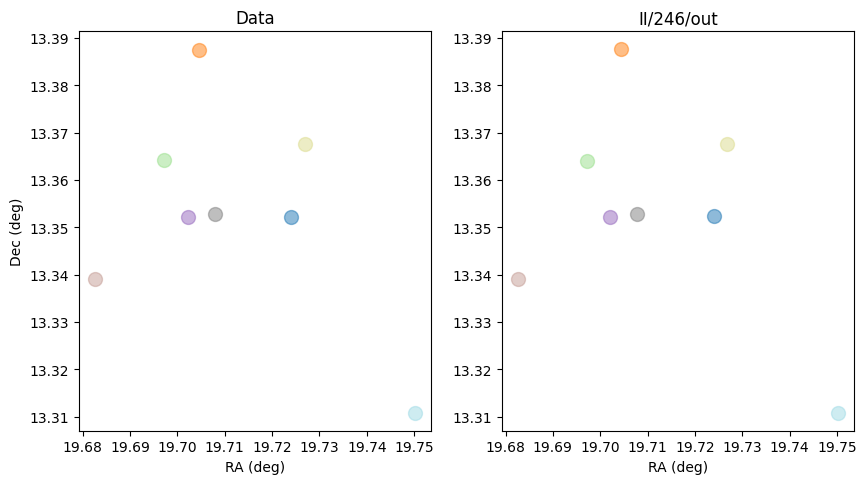

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
ax1, ax2 = axes
# get discretized list of colors from plt
colors = plt.cm.get_cmap('tab20', len(filtered_sources))
for i in range(len(filtered_sources)):
    ref_row = filtered_ref[df_min_distances['catalog_reference'].iloc[i]]
    ax1.scatter(filtered_sources["RA"][i], filtered_sources["Dec"][i], c=colors(i), s=100, alpha=0.5)
    ax2.scatter(ref_row["RAJ2000"], ref_row["DEJ2000"], c=colors(i), s=100, alpha=0.5)

ax1.set_xlabel('RA (deg)')
ax1.set_ylabel('Dec (deg)')
ax1.set_title('Data')
ax1.set_aspect(1)
# apply ax1's x and y limits to ax2:
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('RA (deg)')
ax2.set_ylim(ax1.get_ylim())
# make ax2 square 
ax2.set_aspect(1)
ax2.set_title(catalog)

plt.show()


In [ ]:
# 2MASS to BVRI:  "Transformations between 2MASS, SDSS and BVRI photometric systems: bridging the near-infrared and optical"

# SDSS to BVRI:  https://www.sdss.org/dr16/algorithms/sdssubvritransform/


In [ ]:

# average (?) their apparent magnitudes over all the frames
# calibrate each image